# Part 2: Denoising Autoencoder

In [0]:
# Execute this code block to install dependencies when running on colab
try:
    import torch
except:
    from os.path import exists
    from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
    platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
    cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
    accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

    !pip install -q http://download.pytorch.org/whl/{accelerator}/torch-1.0.0-{platform}-linux_x86_64.whl torchvision

### Extend the Autoencoder you implemented in Part 1 to a Denoising Autoencoder

Recall from the lecture, a denoising autoencoder's architecture is very similar to a standard autoencoder. The difference is **the input to the autoencoder has noise added to it**. However, **when computing the loss function, make sure the original (non-noisy) version is used for backpropagation**.

Again, let's start by loading the Fashion-MNIST dataset and transforming it to a flattened tensor.

In [0]:
%matplotlib inline

import torchvision
import torchvision.transforms as transforms

import numpy as np

batch_size = 256
image_dim = 784  # [flattened]

# dataset construction
transform = transforms.Compose([
    transforms.ToTensor(), # convert to tensor
    transforms.Lambda(lambda x: x.view(image_dim)) # flatten into vector
    ])

train_set = torchvision.datasets.FashionMNIST(
    root='./data/FashionMNIST'
    ,train=True
    ,download=True
    ,transform=transform
)

train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size
)

## Build a Denoising Autoencoder

Now, define the Encoder and Decoder classes for your denoising autoencoder, called DN_Encoder, DN_Decoder, respectively. You can define these architectures how you like; some suggested architectures are given as comments in the classes below.

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from tqdm import tqdm_notebook as tqdm   #######
from itertools import chain


class DN_Encoder(nn.Module):
    '''
    Denoising encoder with a single input, hidden and output layer
    '''
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(DN_Encoder, self).__init__()
        # YOUR CODE HERE
        self.dn_encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(True),   # inplace=True, do the operation in-place
            nn.Linear(hidden_dim, output_dim),
#             nn.ReLU(True)
        )
    
    def forward(self, x):
        # YOUR CODE HERE
        dn_encoded=self.dn_encoder(x)
        return dn_encoded

        
class DN_Decoder(nn.Module):
    '''
    Denoising decoder: single dense hidden layer followed by 
    output layer with a sigmoid to squish values
    '''
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(DN_Decoder, self).__init__()
        # YOUR CODE HERE
        self.dn_decoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(True),
            nn.Linear(hidden_dim, output_dim),
            nn.Sigmoid(),
        )

    def forward(self, x):
        # YOUR CODE HERE
        dn_decoded=self.dn_decoder(x)
        return dn_decoded

## Learning your Denoising Autoencoder 

Start from the training procedure used in Part 1 for the autoencoder and extend this to get your denoising autoencoder working. Again, include images of both the data with added noise as well as the reconstructed images in the submitted notebook. Regarding the noise to add to your images, add Gaussian noise with a mean of 0 and a standard deviation of 1.

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



The first 8 original images of last batch in each epoch, the images addding noise and the reconstructed images after denoising autoencoder:
Epoch:  0
torch.Size([96, 784])


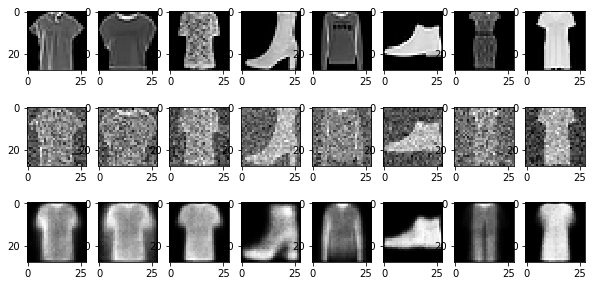


The first 8 original images of last batch in each epoch, the images addding noise and the reconstructed images after denoising autoencoder:
Epoch:  1
torch.Size([96, 784])


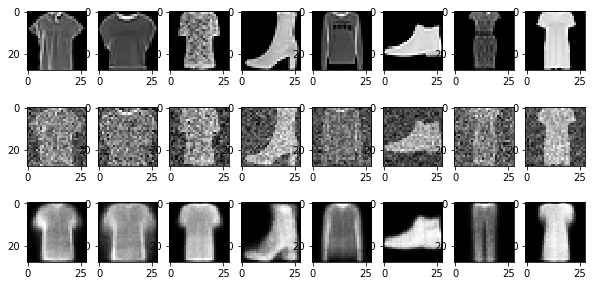


The first 8 original images of last batch in each epoch, the images addding noise and the reconstructed images after denoising autoencoder:
Epoch:  2
torch.Size([96, 784])


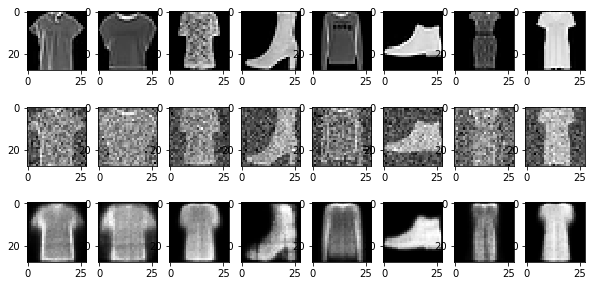


The first 8 original images of last batch in each epoch, the images addding noise and the reconstructed images after denoising autoencoder:
Epoch:  3
torch.Size([96, 784])


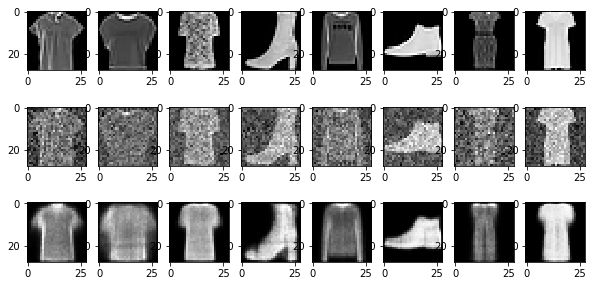


The first 8 original images of last batch in each epoch, the images addding noise and the reconstructed images after denoising autoencoder:
Epoch:  4
torch.Size([96, 784])


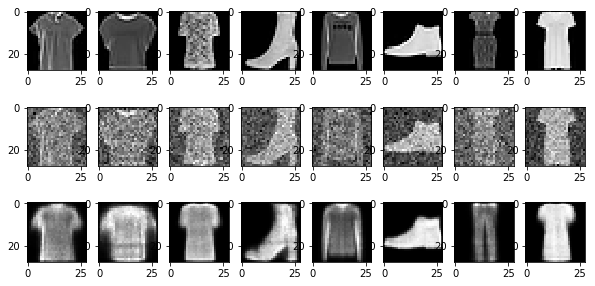


The first 8 original images of last batch in each epoch, the images addding noise and the reconstructed images after denoising autoencoder:
Epoch:  5
torch.Size([96, 784])


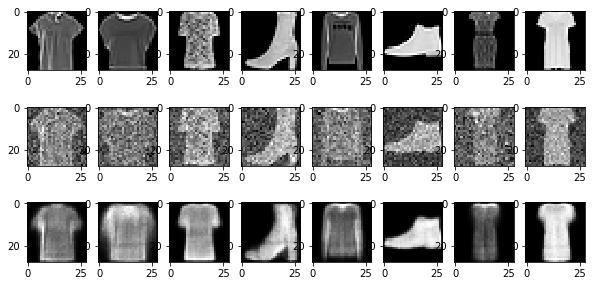


The first 8 original images of last batch in each epoch, the images addding noise and the reconstructed images after denoising autoencoder:
Epoch:  6
torch.Size([96, 784])


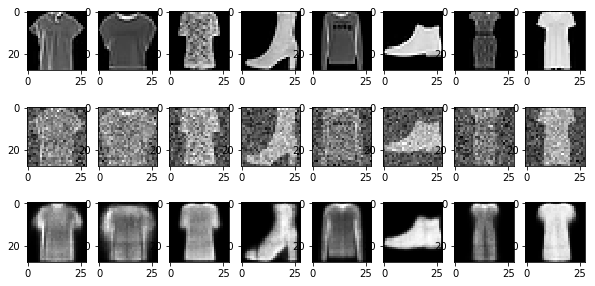


The first 8 original images of last batch in each epoch, the images addding noise and the reconstructed images after denoising autoencoder:
Epoch:  7
torch.Size([96, 784])


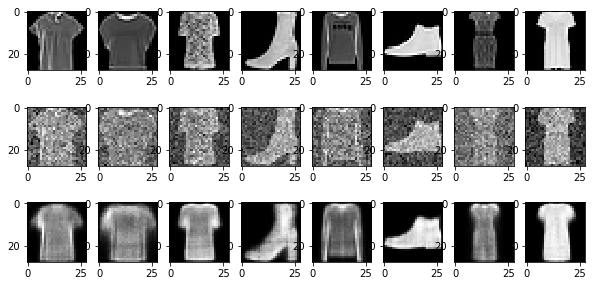


The first 8 original images of last batch in each epoch, the images addding noise and the reconstructed images after denoising autoencoder:
Epoch:  8
torch.Size([96, 784])


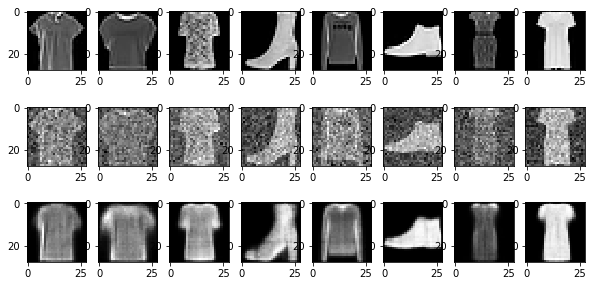


The first 8 original images of last batch in each epoch, the images addding noise and the reconstructed images after denoising autoencoder:
Epoch:  9
torch.Size([96, 784])


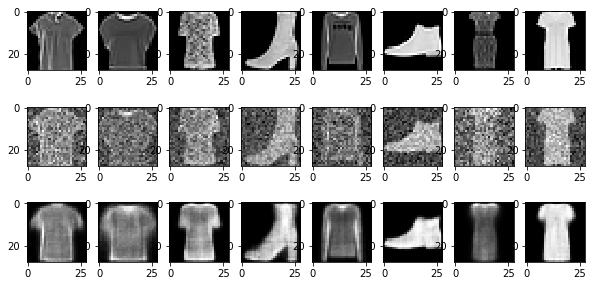

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:53: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


<class 'numpy.ndarray'> (60000, 28, 28)
<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([8, 784])
(784,)
The first 8 original images in the training set, the images addding noise and the reconstructed images after denoising autoencoder:


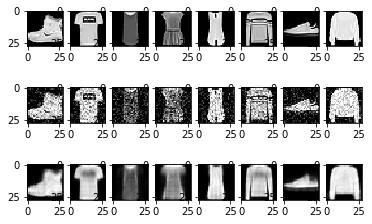

In [0]:
# YOUR CODE HERE
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec    
import os
import torch.optim as optim
import numpy as np

from tqdm import tqdm_notebook as tqdm   #######
from itertools import chain

from torch.autograd import Variable

enc_dim = 64
hidden_dim = 256
image_dim = 784  # [flattened]
nEpoch = 10
noise_factor=0.2
n=8

device = "cuda:0" if torch.cuda.is_available() else "cpu"

# construct the encoder, decoder and optimiser
enc = DN_Encoder(image_dim, hidden_dim, enc_dim)
dec = DN_Decoder(enc_dim, hidden_dim, image_dim)
optimizer = optim.Adam(chain(enc.parameters(), dec.parameters()), lr=1e-3)  # chain: consecutive iterable

def add_noise(img_data):
    img_nom = img_data.numpy().astype('float32') / 255
    noise = np.random.normal(loc=0.0, scale=1.0, size=img_nom.shape) * noise_factor
    noise_img = img_nom + noise
    noise_img  = torch.FloatTensor(np.clip(noise_img, 0., 1.))
    return noise_img
  
def add_noise2(img_data):
    noise = torch.randn(img_data.size()) * noise_factor 
    noise_img = img_data + noise
    return noise_img

def img_data_nomalise(img_data):
    img_nom = torch.FloatTensor(img_data.numpy().astype('float32') / 255)
    return img_nom
  
# training loop
for epoch in range(nEpoch):
    losses = []
    trainloader = tqdm(train_loader)  # add iterator to the progress

    # i: batch index
    for i, data in enumerate(trainloader, 0): # 0: start from 0
        inputs, _ = data  # inputs: batch data, _: batch label
        optimizer.zero_grad()  # Sets gradients of all model parameters to zero
        
#         inputs = inputs.view(inputs.size(0),-1)
        inputs_noise = add_noise2(inputs)
        z = enc(inputs_noise)
        outputs = dec(z)
        
#         inputs_nom=img_data_nomalise(inputs)
        
        loss = F.binary_cross_entropy(outputs, inputs, size_average=False) / inputs.shape[0]  # size_average=False: the losses are instead summed for each minibatch
        loss.backward()
        optimizer.step()  # Performs a single optimization step (parameter update)

        # keep track of the loss and update the stats
        losses.append(loss.item())
        trainloader.set_postfix(loss=np.mean(losses), epoch=epoch)
    
    print("The first 8 original images of last batch in each epoch, the images addding noise and the reconstructed images after denoising autoencoder:")
    print('Epoch: ', epoch)
    f, a = plt.subplots(3, n,figsize=(10, 5))
    print(inputs_noise.shape)  # [96,28*28]
    for j in range(n):
        a[0][j].imshow(np.reshape(inputs[j],(28,28)), cmap=plt.get_cmap('gray'))
        a[1][j].imshow(np.reshape(inputs_noise[j],(28,28)), cmap=plt.get_cmap('gray'))
        a[2][j].imshow(np.reshape(outputs.data.numpy()[j], (28, 28)), cmap=plt.get_cmap('gray'))

    plt.show()    

noise_factor = 0.2
img_size = 28
x_train = train_set.train_data.numpy().astype('float32') / 255   ##### have to nomalise
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
print(type(x_train_noisy),x_train_noisy.shape)

n = 8
view_data = Variable(torch.FloatTensor(x_train_noisy[:n]).view(-1, 28*28))  ####### don't have to nomalise, before already nomalise
view_middle = enc(view_data)
view_outputs = dec(view_middle)
print(type(view_outputs),type(view_outputs.data),view_outputs.data.shape)
print(view_outputs.data.numpy()[0].shape)

print("The first 8 original images in the training set, the images addding noise and the reconstructed images after denoising autoencoder:")
f, a = plt.subplots(3, n)
for j in range(n):
    a[0][j].imshow(train_set.train_data[j], cmap=plt.get_cmap('gray'))
    a[1][j].imshow(x_train_noisy[j], cmap=plt.get_cmap('gray'))
    a[2][j].imshow(np.reshape(view_outputs.data.numpy()[j], (28, 28)), cmap=plt.get_cmap('gray'))

plt.show()

**The below is the first 8 original images in the training set, the images addding noise and the reconstructed images after denoising autoencoder:**

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:53: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


torch.Size([60000, 28, 28])
tensor(221, dtype=torch.uint8)
<class 'numpy.ndarray'> (60000, 28, 28)
<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([8, 784])
(784,)
The first 8 original images in the training set, the images addding noise and the reconstructed images after denoising autoencoder:


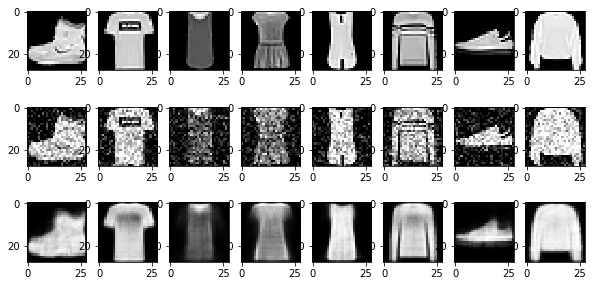

In [0]:
from torch.autograd import Variable

set_shape = train_set.train_data.shape  # [60000,28,28]
print(set_shape)
print(train_set.train_data[0][15][15])

noise_factor = 0.2
img_size = 28
x_train = train_set.train_data.numpy().astype('float32') / 255   ##### have to nomalise
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
print(type(x_train_noisy),x_train_noisy.shape)
    
# for i in range(8):
#     plt.subplot(int(str(24)+str(i+1)))
#     plt.imshow(x_train_noisy[i], cmap=plt.get_cmap('gray'))

# plt.show()

n = 8
view_data = Variable(torch.FloatTensor(x_train_noisy[:n]).view(-1, 28*28))  ####### don't have to nomalise, before already nomalise
view_middle = enc(view_data)
view_outputs = dec(view_middle)
print(type(view_outputs),type(view_outputs.data),view_outputs.data.shape)
print(view_outputs.data.numpy()[0].shape)

print("The first 8 original images in the training set, the images addding noise and the reconstructed images after denoising autoencoder:")
f, a = plt.subplots(3, n, figsize=(10, 5))
for j in range(n):
    a[0][j].imshow(train_set.train_data[j], cmap=plt.get_cmap('gray'))
    a[1][j].imshow(x_train_noisy[j], cmap=plt.get_cmap('gray'))
    a[2][j].imshow(np.reshape(view_outputs.data.numpy()[j], (28, 28)), cmap=plt.get_cmap('gray'))

plt.show()